In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.preprocessing import image as keras_image
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pickle
import random
import time
import zipfile
from shutil import copyfile
import struct
from sklearn.model_selection import train_test_split

In [2]:
def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result

In [3]:
def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image

In [4]:
def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:
        data = binary_file.read()
        offset = 0
        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2
        m = struct.unpack_from('B', data, offset)[0]
        offset += 1
        d = struct.unpack_from('B', data, offset)[0]
        offset += 1
        H = struct.unpack_from('B', data, offset)[0]
        offset += 1
        W = struct.unpack_from('B', data, offset)[0]
        offset += 1
        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4
        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4
        imgType = struct.unpack_from('B', data, offset)[0]
        offset += 1
        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1
        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1
            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1
                H = struct.unpack_from('B', data, offset)[0]
                offset += 1
            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2
            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0
                        else:
                            image[y, counter:counter + WBcount] = 255
                        bWhite = not bWhite
                        counter += WBcount
            else:
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels

In [5]:
def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=int)

    for i in range(len(images)):
        image = images[i]
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        image = image / 255
        image = np.where(image >= 0.5, 1, 0)
        X[i] = image
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [6]:
IMG_SIZE=32

In [7]:
X_train, y_train = read_hoda_dataset(dataset_path=r"C:\Users\ILiYA\Desktop\Project\Data Set\numbers\Train 60000.cdb",
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

X_val = X_train[45000:]
y_val = y_train[45000:]
X_train = X_train[:45000]
y_train = y_train[:45000]

In [8]:
X_test, y_test = read_hoda_dataset(dataset_path=r"C:\Users\ILiYA\Desktop\Project\Data Set\numbers\Test 20000.cdb",
                                images_height=IMG_SIZE,
                                images_width=IMG_SIZE,
                                one_hot=False,
                                reshape=True)

In [9]:
X_train[0].shape

(1024,)

In [10]:
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE)
X_test = X_test.reshape(X_test.shape[0], IMG_SIZE,IMG_SIZE)
X_val=X_val.reshape(X_val.shape[0], IMG_SIZE,IMG_SIZE)

In [11]:
X_train[0].shape

(32, 32)

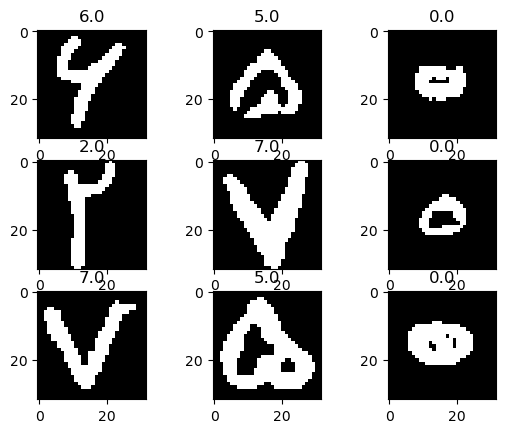

In [12]:
for i in range(9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [13]:
def preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val):
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
  X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  X_val = X_val.astype('float32')
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)
  y_val = to_categorical(y_val)
  return X_train, y_train, X_test, y_test,X_val,y_val

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def LeNet():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(32, 32, 1), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(1e-4)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    opt = Adam()
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [15]:
LeNet_model = LeNet()
LeNet_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                      

In [16]:
def summary_history(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train_acc')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val_acc')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

def train_model(model, X_train, y_train, X_test, y_test,X_val,y_val, epochs = 30, batch_size = 128):
  X_train, y_train, X_test, y_test,X_val,y_val= preprocess_data(X_train, y_train, X_test, y_test,X_val,y_val)
  history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size,
                      steps_per_epoch = X_train.shape[0]//batch_size,
                      validation_data = (X_val,y_val),
                      validation_steps = X_val.shape[0]//batch_size)
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))
  summary_history(history)

Epoch 1/30


351/351 [==============================] - 19s 48ms/step - loss: 0.5050 - accuracy: 0.8543 - val_loss: 0.1025 - val_accuracy: 0.9808
Epoch 2/30
351/351 [==============================] - 17s 48ms/step - loss: 0.1632 - accuracy: 0.9665 - val_loss: 0.0862 - val_accuracy: 0.9863
Epoch 3/30
351/351 [==============================] - 16s 45ms/step - loss: 0.1231 - accuracy: 0.9779 - val_loss: 0.0699 - val_accuracy: 0.9919
Epoch 4/30
351/351 [==============================] - 16s 44ms/step - loss: 0.1052 - accuracy: 0.9833 - val_loss: 0.0678 - val_accuracy: 0.9929
Epoch 5/30
351/351 [==============================] - 16s 45ms/step - loss: 0.0969 - accuracy: 0.9861 - val_loss: 0.0661 - val_accuracy: 0.9943
Epoch 6/30
351/351 [==============================] - 15s 43ms/step - loss: 0.0944 - accuracy: 0.9859 - val_loss: 0.0662 - val_accuracy: 0.9937
Epoch 7/30
351/351 [==============================] - 18s 51ms/step - loss: 0.0872 - accuracy: 0.9893 - val_loss: 0.0636 - val_accurac

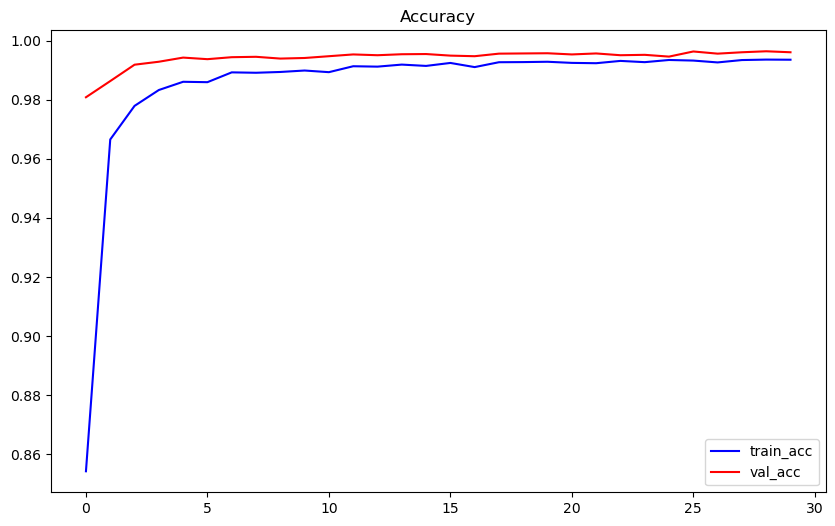

In [17]:
train_model(LeNet_model, X_train, y_train, X_test, y_test,X_val,y_val)

In [18]:
from tensorflow.keras.models import save_model
save_model(LeNet_model, r"C:\Users\ILiYA\Desktop\Project\Models\trained numebr detection\LeNet_model.keras")
save_model(LeNet_model, r"C:\Users\ILiYA\Desktop\Project\Models\trained numebr detection\LeNet_model.h5")

C:\Users\ILiYA\AppData\Local\Temp\ipykernel_6536\404048353.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(LeNet_model, r"C:\Users\ILiYA\Desktop\Project\Models\trained numebr detection\LeNet_model.h5")
